In [1]:
##import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from textwrap import wrap
from PIL import Image
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet201

In [2]:
image_path = "C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images"

In [3]:
data = pd.read_csv("C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
# Function to preprocess images
def preprocess_image(image_file, target_size=224, apply_filter=False):
    # Load the image
    img = Image.open(os.path.join(image_path, image_file))
    
    # Resize the image maintaining the aspect ratio
    img.thumbnail((target_size, target_size), Image.LANCZOS)
    
    # Create a new image with a white background and centers the resized image on the new background
    new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    new_img.paste(img, ((target_size - img.width) // 2, (target_size - img.height) // 2))
    
    # Convert the image to a NumPy array
    img_array = img_to_array(new_img)
    
    # Normalize the image data to the range [0, 1]
    img_array = img_array / 255.0
    
    # Optionally apply a filter
    img_array_blur = cv2.GaussianBlur(img_array, (5, 5), 0)
    # we can also use edge detection: image_array_edges = cv2.Canny((image_array[0] * 255).astype(np.uint8), 100, 200)
    
    # Expand dimensions to add the batch size (1 in this case)
    img_array_blur = np.expand_dims(img_array, axis=0)
    
    return img_array_blur

In [5]:
## Function to display preprocessed images
def check_preprocessed_images(image_files, num_images=5, target_size=224):
    plt.figure(figsize=(15, 15))
    for i, image_file in enumerate(image_files[:num_images]):
        preprocessed_image = preprocess_image(image_file, target_size)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(preprocessed_image[0])
        plt.title(image_file)
        plt.axis('off')
    plt.show()



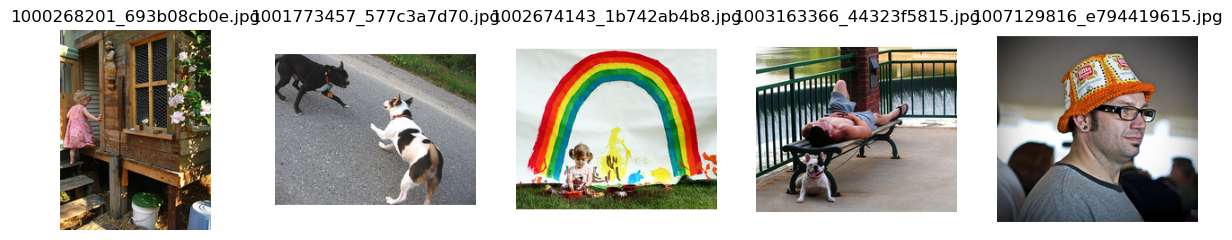

In [6]:
# Sample images to check preprocessing
sample_images = data['image'].unique().tolist()[:10]  # Take first 10 unique image filenames
check_preprocessed_images(sample_images, num_images=5)


In [7]:
#Converts a PIL Image instance to a Numpy array. 
#If you start from a PNG image, the values inside the image will lie between 0 and 255
#img_to_array however will cast to float. In your code example, the array is divided by 255, 
#so that's why you end up with floats between 0 and 1.
#This code is actually for reducing the range of values from 0-255 to 0-1
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)/255
    
    return img
#Reset the index, or a level of it. If the DataFrame has a MultiIndex, this method can remove one or more levels.
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], width = 20)))
        plt.axis("off")

#we wrap the title to a specified width (in this case, 20 characters). 
#We then join the wrapped lines using the newline character (\n) 
#and set the wrapped title as the plot title.

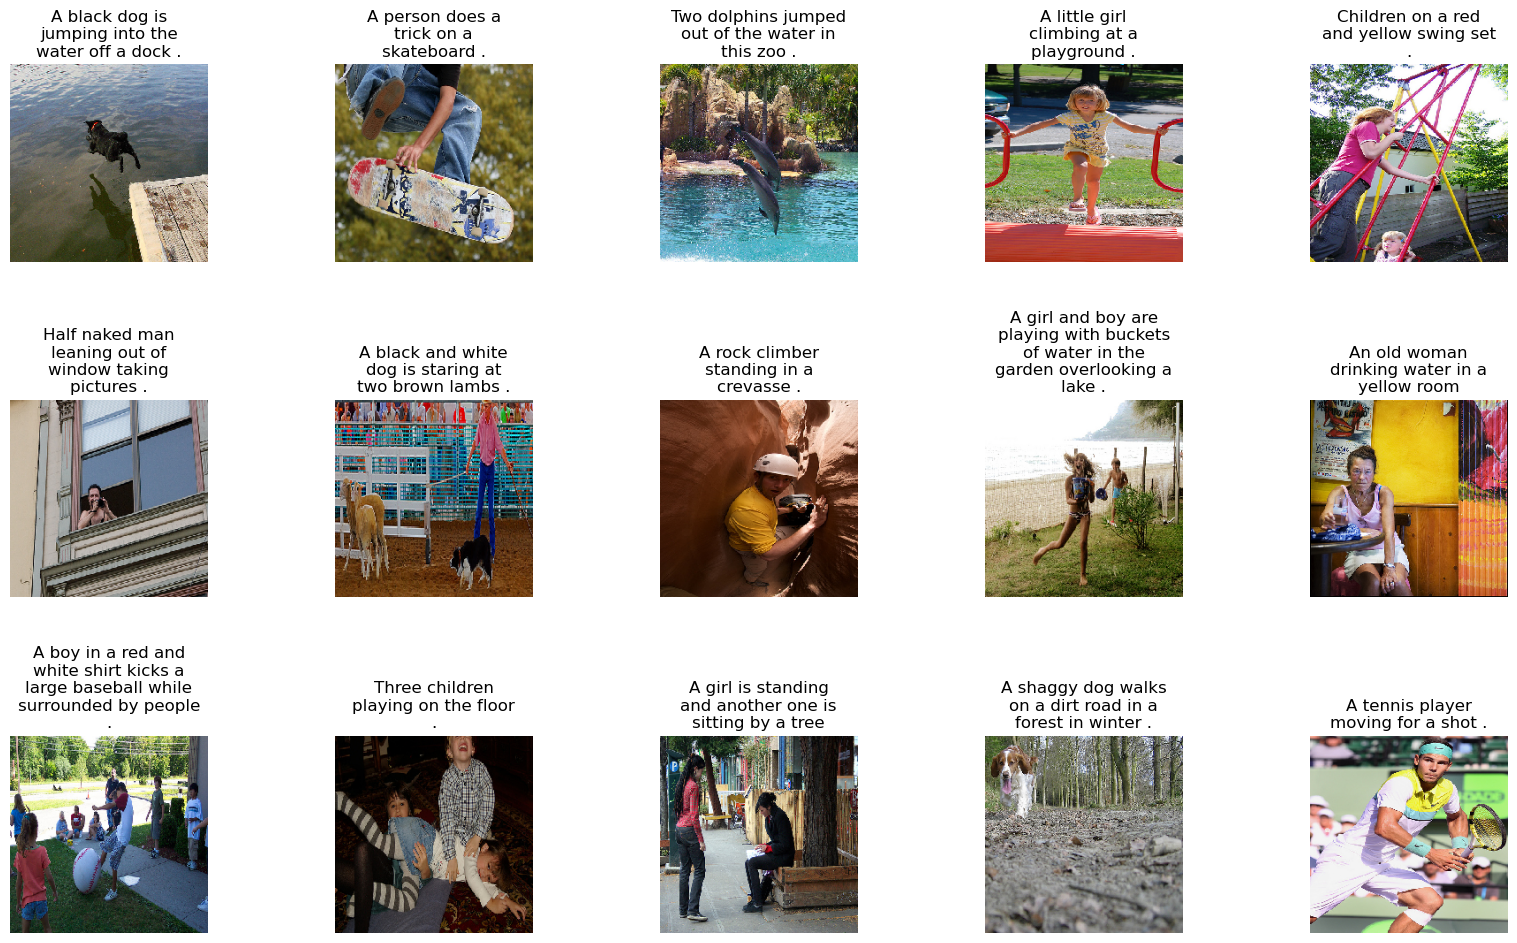

In [8]:
display_images(data.sample(15))

In [9]:
##text preprocessing
##convert to lower case
## delete digits, special chars, etc.
## delete additional spaces
## add start and end tags to the caption
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [11]:
#The words in a sentence are separated/tokenized and encoded in a one hot representation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1


In [12]:
vocab_size

8485

In [13]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in captions)
max_length

34

In [14]:
#train - test split
images = data['image'].unique().tolist()
n_images = len(images)

split_index = round(0.85*n_images)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

#These encodings are then passed to the embeddings layer to generate word embeddings
tokenizer.texts_to_sequences([captions[1]])[0]



[1, 18, 315, 63, 195, 116, 2]

In [28]:
##feature extraction
##DenseNet 201 Architecture is used to extract the features from the image.
##it is a deep convolutional neural network architecture.
#its output is set to be the output of the second-to-last layer of the DenseNet201 model 
model = DenseNet201()
f_extract = Model(inputs=model.input, outputs=model.layers[-2].output)


#img_size is set to 224, which is the target size for the images. 
#features is initialized as an empty dictionary to store the extracted features for each image.
img_size = 224
features = {}

#Looping Through Images and Extracting Features
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = f_extract.predict(img, verbose=0)
    features[image] = feature


# this code loads a pre-trained DenseNet201 model, modifies it to extract features,
# and then iterates through a set of images to extract and store these features in a dictionary

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [44:31<00:00,  3.03it/s]
